In [278]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pandas as pd
from pymc.Matplot import plot as pmplot
from matplotlib.ticker import StrMethodFormatter

import scipy.stats as sps


sns.set()

[410.]
 [-----------------100%-----------------] 100000 of 100000 complete in 17.1 sec
370.8285946252171
372.799851639478
0.00824
0.00824


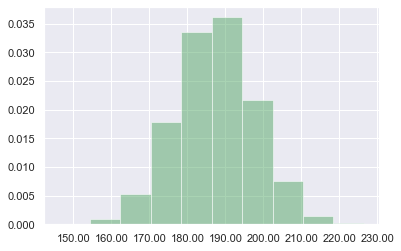

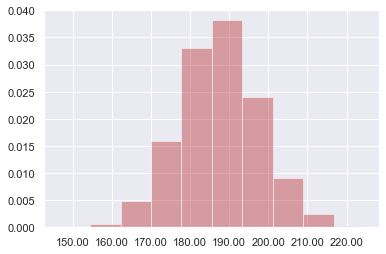

In [279]:
# with data - posterior distribution

x1 = pm.Normal('x1',mu=185,tau = 1 / 10 ** 2)
x2 = pm.Normal('x2',mu=185,tau = 1 / 10 ** 2)

obs_sigma = pm.Uniform('obs_sigma',0,100)

nr_pairs = 1
data = np.ones(nr_pairs) * 410 # combined length of two people
print (data)

@pm.deterministic
def two_tall_people(x1=x1,x2=x2):
    out = np.ones(len(data)) * (x1 + x2) 
    return out

obs = pm.Normal('obs',two_tall_people,1 / obs_sigma ** 2,observed=True,value=np.array(data))

model = pm.Model([x1,x2,two_tall_people,obs,obs_sigma])

map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

sample = mcmc.sample(100000,50000,2)

x1_post = mcmc.trace('x1')[:]
x2_post = mcmc.trace('x2')[:]
two_tall_post = mcmc.trace('two_tall_people')[:]


#pmplot(x1_post,'x1')
#pmplot(x2_post,'x2')
#pmplot(two_tall_post,'two_tall_people')

plt.figure()
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
#plt.ticklabel_format(useOffset=False)
plt.hist(x1_post,color='g',alpha=0.5,density=True)
plt.figure()
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
#plt.ticklabel_format(useOffset=False)
_ = plt.hist(x2_post,color='r',alpha=0.5,density=True)
print()
print (x1_post.min() + x2_post.max())
print (x1_post.max() + x1_post.min())

print ((x1_post + x2_post >= 410).sum() / len(x1_post))
print ((x1_post + x2_post >= 410).mean())

 [-----------------100%-----------------] 100 of 100 complete in 0.0 sec

/usr/lib/python3.6/site-packages/pymc/NormalApproximation.py:374: RuntimeWarning: divide by zero encountered in log
  self.data_len) - 2. * lnL  # k ln(n) - 2 ln(L)


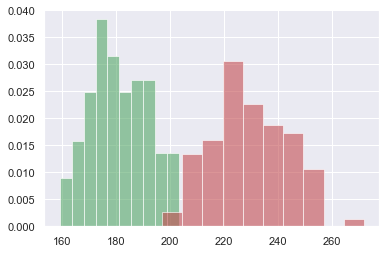

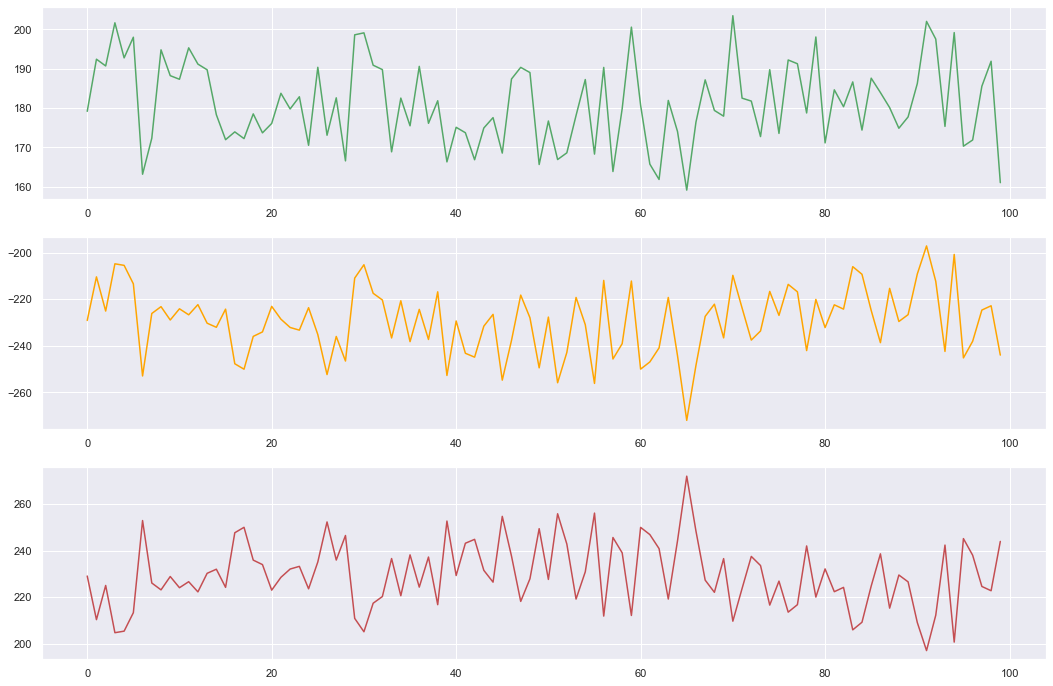

In [280]:
#without data - prior distribution
# x1 + x2 = 410
# x2 = 410 - x1
x1 = pm.Normal('x1',mu=180,tau = 1 / 10 ** 2)
x2 = pm.Normal('x2',mu=410-x1,tau = 1 / 10 ** 2)

model = pm.Model([x1,x2])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)
sample = mcmc.sample(100)

x1_trace = mcmc.trace('x1')[:]
x2_trace = mcmc.trace('x2')[:]

plt.hist(x1_trace,density=True,color='g',alpha=0.6)
plt.hist(x2_trace,density=True,color='r',alpha=0.6)

plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(x1_trace,color='g')
plt.subplot(312)
plt.plot(-x2_trace,color='orange')
plt.subplot(313)
plt.plot(x2_trace,color='r')

In [281]:
## trap of averages with low sample sizes - hacker book

nr_counties = 5000
p = 0.5

def gen_population():
    pop = pm.rdiscrete_uniform(1,500,size=nr_counties)
    return pop

def gen_dead(popsize):
    l = pm.rbernoulli(p=p,size=popsize)
    return l

pop_df = pd.DataFrame({'population':gen_population()})
pop_df.index.name='country_nr'
pop_df.sort_values('population',inplace=True)
pop_df.reset_index(inplace=True)
pop_df.head()



,country_nr,population
0,4462,1
1,4825,1
2,489,1
3,2206,1
4,323,1


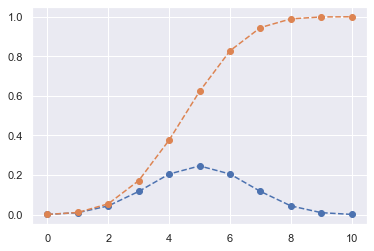

In [282]:

n = 10
p = 0.5
binom = sps.binom.pmf(range(n+1),n,p)
binom_cdf = sps.binom.cdf(range(n+1),n,p)
plt.plot(binom,'o--')
plt.plot(binom_cdf,'o--')

In [283]:

pop_df['is_dead'] = pop_df['population'].apply(gen_dead)
pop_df['nr_dead'] = pop_df['is_dead'].apply(np.sum)
pop_df['ratio_dead'] = pop_df['is_dead'].apply(np.mean)
pop_df['expectation'] = pop_df.apply(lambda row: sps.binom.ppf(pop_df['ratio_dead'].mean(),
                                                                row.population,pop_df['ratio_dead'].mean()),axis=1)

def percentile(s):
    return np.percentile(s,[5.5,94.5])

intervals = pd.DataFrame(pop_df.groupby('population')['nr_dead'].apply(percentile))
intervals
intervals = pd.DataFrame(intervals['nr_dead'].to_list(),columns=['low','high'])

intervals['pop'] = (range(1,501))
intervals['low'] = intervals['low'] / intervals['pop']
intervals['high'] = intervals['high'] / intervals['pop']


pop_df.tail(40)


,country_nr,population,is_dead,nr_dead,ratio_dead,expectation
4960,565,497,"[False, True, False, False, False, True, False...",243,0.488934,249.0
4961,3527,497,"[True, True, True, True, True, False, False, T...",256,0.515091,249.0
4962,2565,497,"[True, False, False, False, False, True, True,...",238,0.478873,249.0
4963,312,497,"[False, False, True, False, False, False, Fals...",234,0.470825,249.0
4964,2948,497,"[True, True, True, False, True, True, True, Fa...",240,0.482897,249.0
4965,3071,498,"[False, False, False, False, True, False, Fals...",243,0.487952,250.0
4966,3274,498,"[True, False, True, True, True, False, True, F...",229,0.459839,250.0
4967,4582,498,"[True, False, True, False, True, True, False, ...",255,0.512048,250.0
4968,1992,498,"[False, False, False, False, False, True, True...",250,0.502008,250.0
4969,4243,498,"[False, False, True, True, True, True, False, ...",243,0.487952,250.0


In [284]:

pop_df.head(40)

,country_nr,population,is_dead,nr_dead,ratio_dead,expectation
0,4462,1,[False],0,0.000000,1.0
1,4825,1,[False],0,0.000000,1.0
2,489,1,[False],0,0.000000,1.0
3,2206,1,[True],1,1.000000,1.0
4,323,1,[True],1,1.000000,1.0
5,1294,1,[True],1,1.000000,1.0
6,958,1,[True],1,1.000000,1.0
7,2402,1,[True],1,1.000000,1.0
8,1111,1,[False],0,0.000000,1.0
9,1191,2,"[True, True]",2,1.000000,1.0


In [285]:
pop_df.describe()

,country_nr,population,nr_dead,ratio_dead,expectation
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,248.217200,124.021800,0.501107,124.433600
std,1443.520003,144.494885,72.553531,0.059531,72.358902
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,1249.750000,121.000000,60.000000,0.477064,61.000000
50%,2499.500000,248.000000,123.000000,0.500000,124.000000
75%,3749.250000,373.000000,186.000000,0.523508,187.000000
max,4999.000000,500.000000,270.000000,1.000000,251.000000


             country_nr     nr_dead  ratio_dead  expectation
population                                                  
1           2007.777778    0.555556    0.555556          1.0
2           2668.200000    1.100000    0.550000          1.0
3           3104.666667    1.666667    0.555556          2.0
4           2926.900000    2.000000    0.500000          2.0
5           2542.812500    3.062500    0.612500          3.0
...                 ...         ...         ...          ...
496         2856.545455  251.545455    0.507148        249.0
497         2156.000000  246.250000    0.495473        249.0
498         2814.722222  246.333333    0.494645        250.0
499         2747.375000  251.375000    0.503758        250.0
500         2495.333333  249.111111    0.498222        251.0

[500 rows x 4 columns]


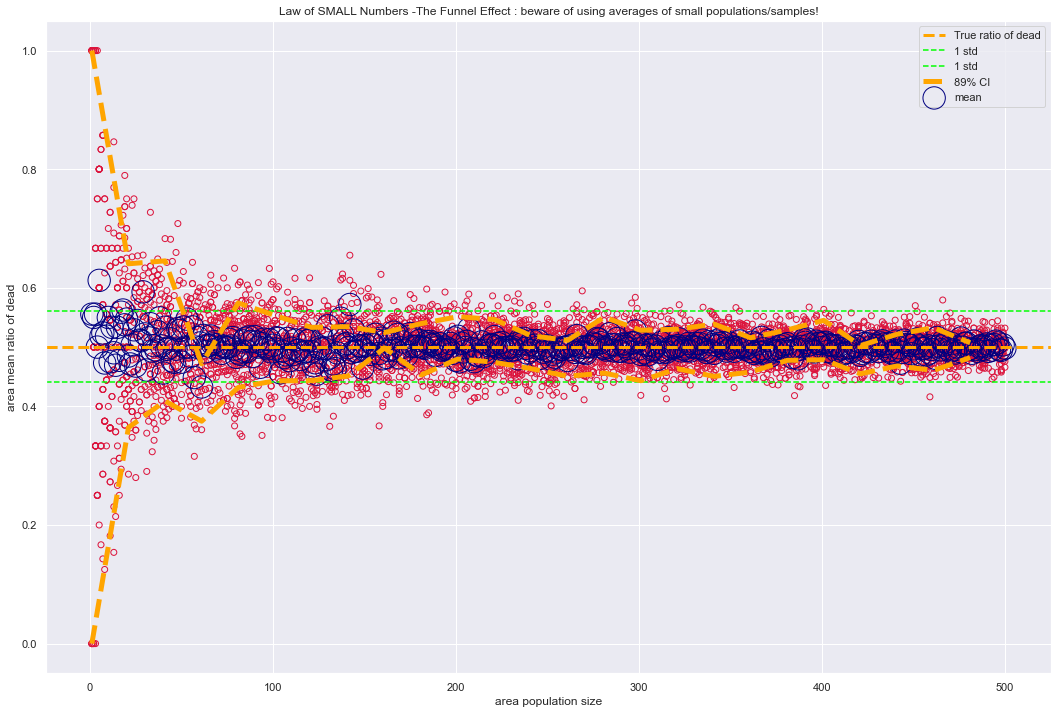

In [286]:


plt.figure(figsize=(18,12))
plt.title('Law of SMALL Numbers -The Funnel Effect : beware of using averages of small populations/samples!')
plt.scatter(pop_df['population'],pop_df['ratio_dead'],facecolor='none',edgecolor='crimson')
plt.xlabel('area population size')
plt.ylabel('area mean ratio of dead')
plt.axhline(p,ls='dashed',color='orange',lw=3,label='True ratio of dead')
plt.axhline(pop_df['ratio_dead'].mean() - pop_df['ratio_dead'].std(),color='lime',ls='dashed',label='1 std')
plt.axhline(pop_df['ratio_dead'].mean() + pop_df['ratio_dead'].std(),color='lime',ls='dashed',label='1 std')


pop_groups = pop_df.groupby('population').mean()
print (pop_groups)
sub = 1
plt.scatter(pop_groups.index[::sub],pop_groups['ratio_dead'][::sub],edgecolors='navy',facecolors='none',s=500,
           label='mean')


sub = 20
plt.plot(intervals['pop'][::sub],intervals['low'][::sub],ls='dashed',color='orange',lw=5,label='89% CI')
plt.plot(intervals['pop'][::sub],intervals['high'][::sub],ls='dashed',color='orange',lw=5)


plt.legend(loc='upper right')
plt.savefig('Law_of_averages_of_small_samples.jpg',format='jpg')


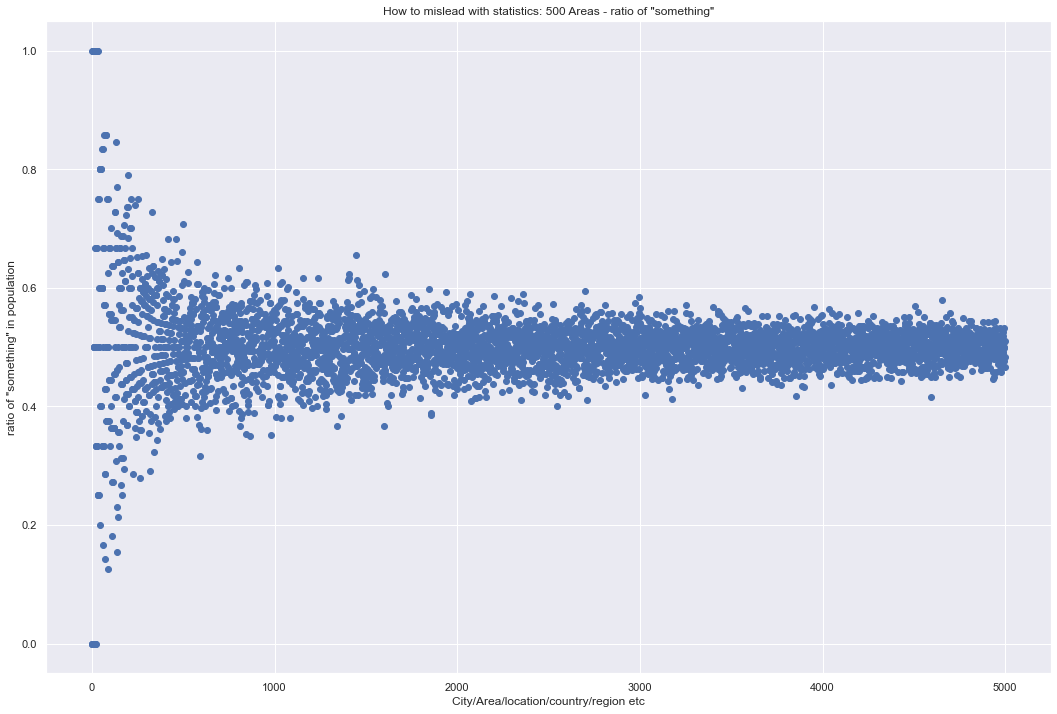

In [287]:
plt.figure(figsize=(18,12))
plt.title('How to mislead with statistics: 500 Areas - ratio of "something"')
plt.xlabel('City/Area/location/country/region etc')
plt.ylabel('ratio of "something" in population')
#pop_df.set_index('country_nr',inplace=True)
plt.plot(pop_df.index,pop_df['ratio_dead'],'o')
plt.savefig('Law_of_agerages_alarming_stats.jpg',format='jpg')

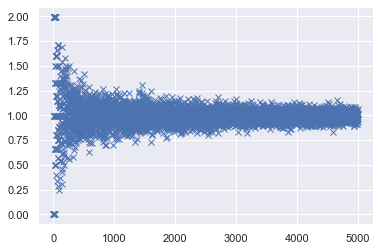

In [288]:
plt.plot(pop_df['ratio_dead'] / pop_df['ratio_dead'].mean(),'x')

(10, 100)
(10, 10)
     observed_mean  samples_mean  sample_ci_low  sample_ci_high
day                                                            
0        10.355334     12.698648       6.989242       18.727267
1        20.417037     20.682009      15.627099       26.915984
2        30.185061     33.278524      28.460388       37.800825
3        40.374955     42.090971      34.687239       48.323694
4        49.325204     52.283565      44.906103       60.357234
5        60.117657     62.512697      53.137153       69.603966
6        69.742715     72.737698      65.140074       79.757791
7        79.357352     86.418803      82.356059       91.862075
8        89.563412     89.159806      85.688505       92.869779
9        99.747161    102.913982      94.135628      109.727124


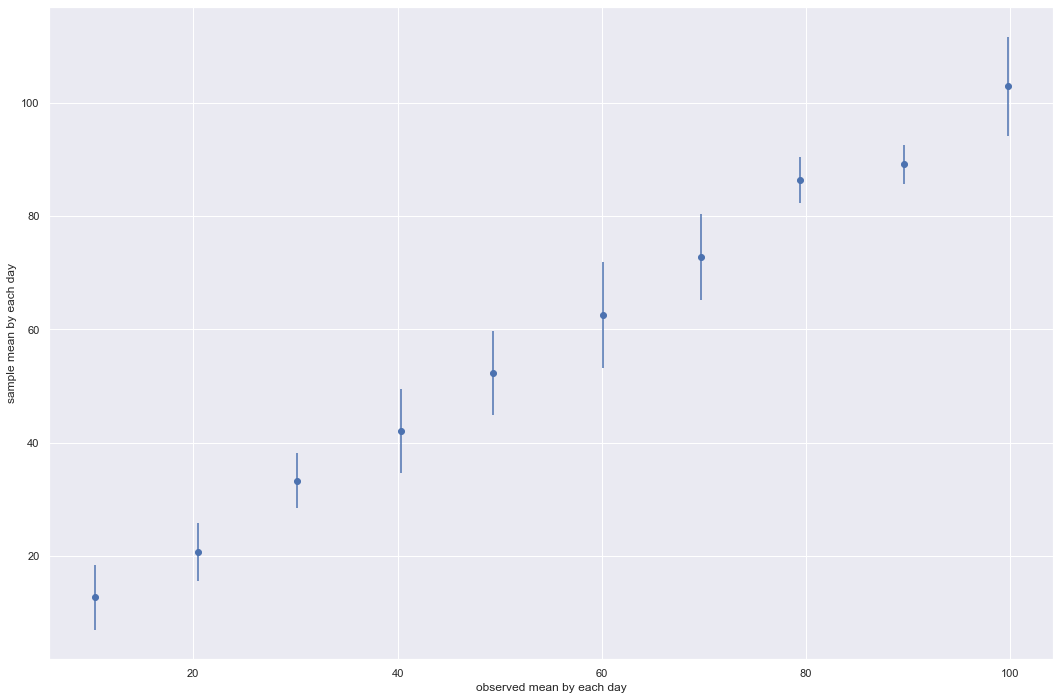

In [289]:
# observed vs samples

days = 10
observed_per_day = 100
samples_per_day = 10

observed = np.zeros((days,observed_per_day))
samples = np.zeros((days,samples_per_day))

print (observed.shape)
print (samples.shape)

for d in range(0,days):
    observed[d] = np.random.normal((d + 1) * 10 ,5,observed_per_day)
    samples[d] = np.random.normal((d + 1) * 10, 5,samples_per_day)
    samples[d] += np.random.randint(1,5,samples_per_day)

### samples and observed are two dimensional with same nr of rows
def observed_vs_samples(observed,samples):
    
    observed_mean_per_day = np.mean(observed,axis=1)
    sample_mean_per_day = np.mean(samples,axis=1)

    df = pd.DataFrame({'observed_mean' : observed_mean_per_day,
                      'samples_mean' : sample_mean_per_day})

    df.index.name= 'day'
    df['sample_ci_low'] = np.percentile(samples,[5.5,94.5],axis=1)[0]
    df['sample_ci_high'] = np.percentile(samples,[5.5,94.5],axis=1)[1]

    plt.figure(figsize=(18,12))
    plt.errorbar(df['observed_mean'],df['samples_mean'],
                 np.array(np.abs(df['samples_mean'] - df['sample_ci_low']),
                          np.abs(df['samples_mean'] - df['sample_ci_high'])),
                fmt='o')
    
    plt.xlabel('observed mean by each day')
    plt.ylabel('sample mean by each day')
    print (df)
    
_ = observed_vs_samples(observed,samples)

In [290]:
resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
today = pd.datetime.today().weekday()

yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

for i in range (7):
    print (i,resample_period[today],yesterday(today))
    
today

0 W-WED W-TUE
1 W-WED W-TUE
2 W-WED W-TUE
3 W-WED W-TUE
4 W-WED W-TUE
5 W-WED W-TUE
6 W-WED W-TUE


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


2

In [291]:
some_dates = pd.date_range('2020-01-01','2020-01-31')
start = pd.to_datetime('2020-01-10')
end = pd.to_datetime('2020-01-15')

df = pd.DataFrame(index=some_dates,data=range(len(some_dates)))
df.loc['2020-01-05' : '2020-01-10']

,0
2020-01-05,4
2020-01-06,5
2020-01-07,6
2020-01-08,7
2020-01-09,8
2020-01-10,9


In [292]:
# Water Land

#conjecture : assume prior proportion water is uniform discrete [0..1] with 0.1 steps

conjecture = np.zeros((6,4))
conjecture

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

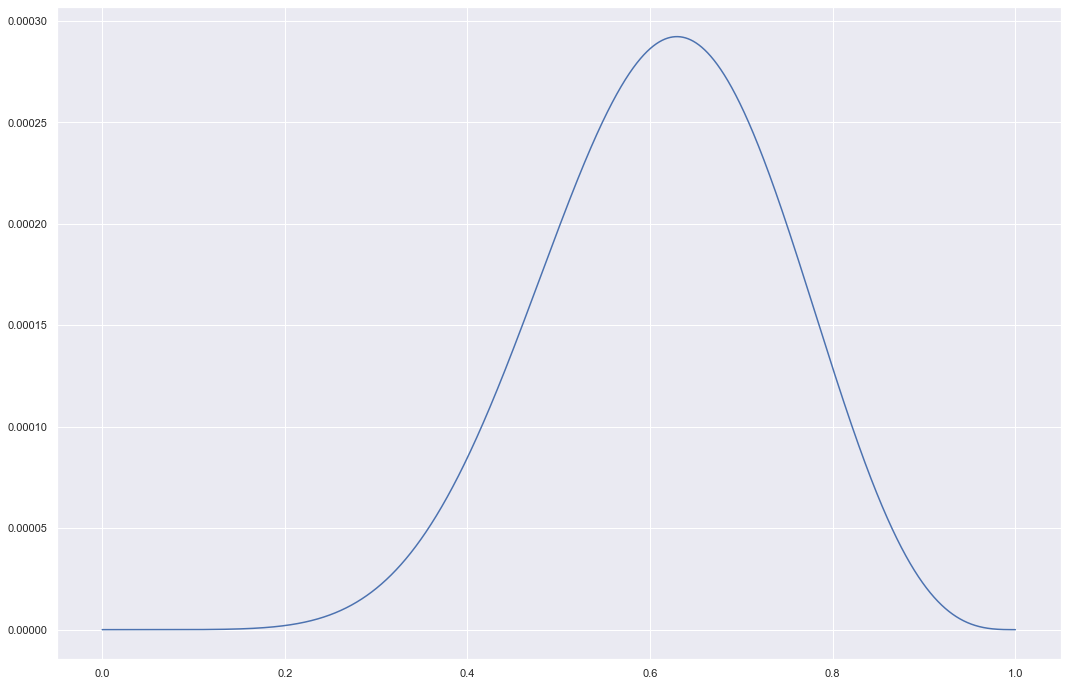

In [293]:
#McElreath Water 

size = 10000
p_grid = np.linspace(0,1,size)

#prior = np.ones_like(p_grid) #uniform prior
#prior = sps.beta.pdf(p_grid,80,40)
prior = sps.norm.pdf(p_grid,0.5,0.3)

plt.figure(figsize=(18,12))

for nr_water in range(1,2):
    likelihood = sps.binom.pmf(6,n=9,p=p_grid) #must be a pmf/pdf, not samples! 
    posterior = prior * likelihood 
    posterior = posterior / posterior.sum()

    _= plt.plot(p_grid,posterior)



(array([ 419., 2391., 3460., 2219.,  996.,  388.,   82.,   36.,    5.,
           4.]),
 array([0.50507374, 0.76181171, 1.01854968, 1.27528765, 1.53202562,
        1.78876359, 2.04550157, 2.30223954, 2.55897751, 2.81571548,
        3.07245345]),
 <a list of 10 Patch objects>)

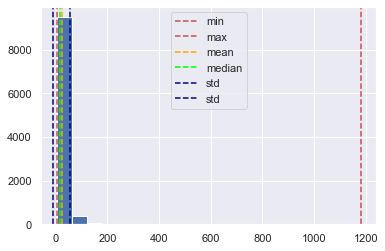

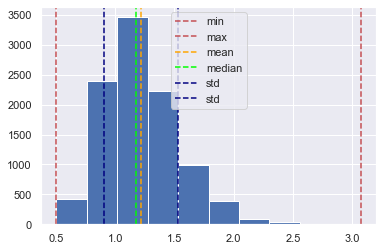

In [294]:
# lognormal

data = np.random.lognormal(1,0.25,10000)
data = np.power(np.e,data)
data_mean = data.mean()

plt.hist(data,bins=20)
plt.axvline(data.min(),color='r',ls='dashed',label='min')
plt.axvline(data.max(),color='r',ls='dashed',label='max')
plt.axvline(data.mean(),color='orange',ls='dashed',label='mean')
plt.axvline(np.median(data),color='lime',ls='dashed',label='median')
plt.axvline(data.mean() - data.std(),color='navy',ls='dashed',label='std')
plt.axvline(data.mean() + data.std(),color='navy',ls='dashed',label='std')


plt.legend(loc='upper center')

plt.figure()
log_data = np.log10(data)
plt.axvline(log_data.min(),color='r',ls='dashed',label='min')
plt.axvline(log_data.max(),color='r',ls='dashed',label='max')
plt.axvline(log_data.mean(),color='orange',ls='dashed',label='mean')
plt.axvline(np.median(log_data),color='lime',ls='dashed',label='median')
plt.axvline(log_data.mean() - log_data.std(),color='navy',ls='dashed',label='std')
plt.axvline(log_data.mean() + log_data.std(),color='navy',ls='dashed',label='std')

plt.legend(loc='upper center')
plt.hist(log_data)

 [-----------------100%-----------------] 50000 of 50000 complete in 4.1 secPlotting lambda_1
Plotting lambda_2
0.0
0.0


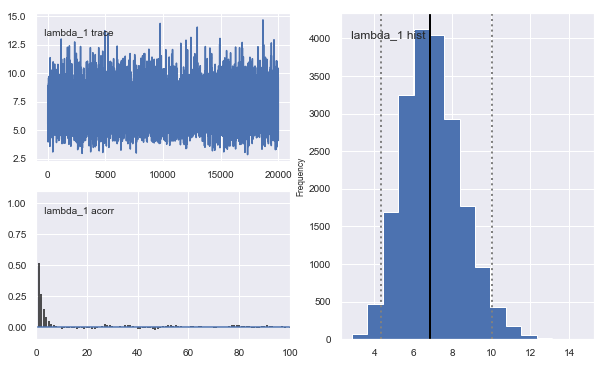

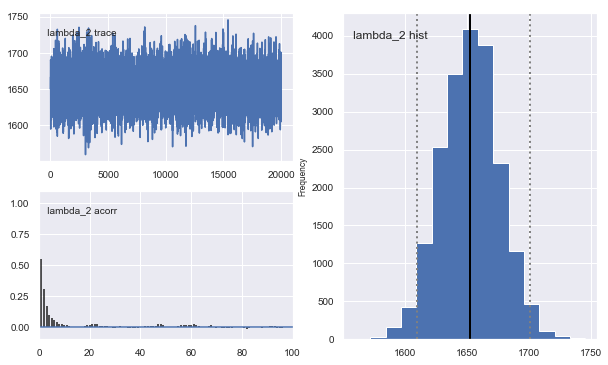

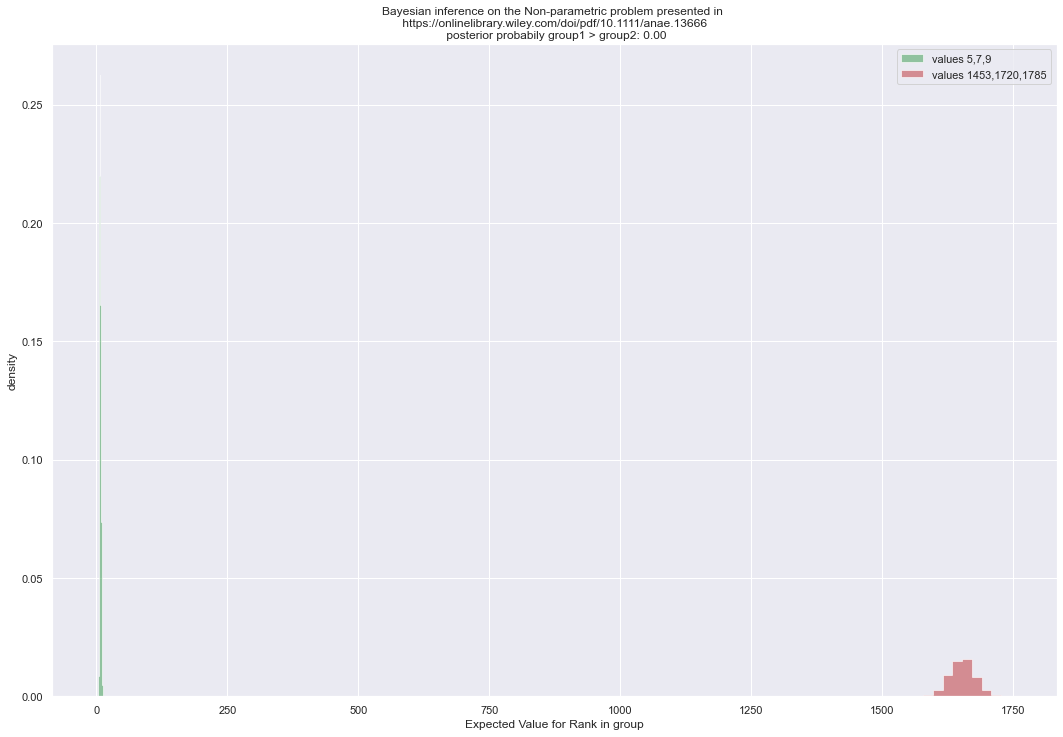

In [295]:
# parametric-non-parametric vs Bayes
# https://onlinelibrary.wiley.com/doi/pdf/10.1111/anae.13666

#data1 = np.array([1,2,3])
data1 = np.array([5,7,9])
#data2 = np.array([4,5,6])
data2 = np.array([1453,1720,1785])

alpha_1 = 1 / data1.mean()
alpha_2 = 1 / data2.mean()

lambda_1 = pm.Exponential('lambda_1',alpha_1)
lambda_2 = pm.Exponential('lambda_2',alpha_2)

obs_1 = pm.Poisson('obs_1',lambda_1,observed=True,value=data1)
obs_2 = pm.Poisson('obs_2',lambda_2,observed=True,value=data2)

model = pm.Model([lambda_1,lambda_2,obs_1,obs_2])

map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

sample = mcmc.sample(50000,10000,2)

lambda_1_post = mcmc.trace('lambda_1')[:]
lambda_2_post = mcmc.trace('lambda_2')[:]

pmplot(lambda_1_post,'lambda_1')
pmplot(lambda_2_post,'lambda_2')

plt.figure(figsize=(18,12))
plt.title('Bayesian inference on the Non-parametric problem presented '\
          'in \n https://onlinelibrary.wiley.com/doi/pdf/10.1111/anae.13666 \n posterior probabily group1 > group2: {:.2f}'.format(
(lambda_1_post > lambda_2_post).mean()))

plt.hist(lambda_1_post,density=True,color='g',histtype='stepfilled',alpha=0.6,label='values 5,7,9')
plt.hist(lambda_2_post,density=True,color='r',histtype='stepfilled',alpha=0.6,label='values 1453,1720,1785')
plt.legend(loc='upper right')
plt.ylabel('density')
plt.xlabel('Expected Value for Rank in group')

print ((lambda_1_post > lambda_2_post).mean())
print ((lambda_1_post > lambda_2_post).sum() / lambda_1_post.size)

plt.savefig('Bayesian_ex_of_p_value_bashing_no_ranks.jpg',format='jpg')

In [296]:
# apply
# DataFrame.apply operates on entire rows or columns at a time.

# DataFrame.applymap, Series.apply, and Series.map operate on one element at time.

def standardize(x):
    return (x - x.mean()) / x.std()

def standardize2(x,mean,std):
    return (x - mean) / std

df = pd.DataFrame({'A': range(0,3),
                  'B': range(3,6),
                  'C': range(6,9)})

print (df)
print (df.apply(np.mean))
print (df.apply(standardize))
# but df['A'].apply(standardize) fails b/c on series it operates on individual elements

print (standardize(df['A']))

print (standardize2(df['A'],df['A'].mean(),df['A'].std()))

print (df['A'].apply(standardize2,args=(df['A'].mean(),df['A'].std())))

   A  B  C
0  0  3  6
1  1  4  7
2  2  5  8
A    1.0
B    4.0
C    7.0
dtype: float64
     A    B    C
0 -1.0 -1.0 -1.0
1  0.0  0.0  0.0
2  1.0  1.0  1.0
0   -1.0
1    0.0
2    1.0
Name: A, dtype: float64
0   -1.0
1    0.0
2    1.0
Name: A, dtype: float64
0   -1.0
1    0.0
2    1.0
Name: A, dtype: float64


In [297]:
print(df)

def my_func(x,y):
    return x + y

df[['A','B']].apply(lambda row: my_func(row['A'],row['B']),axis=1)

   A  B  C
0  0  3  6
1  1  4  7
2  2  5  8


0    3
1    5
2    7
dtype: int64